# 1,4,5

#Libraries to download

# !pip install pydot
# !conda install graphviz

In [212]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.drawing.nx_pydot import graphviz_layout

# Function to compute duration for each activity (no need to calculate TE here)
def compute_duration(activities):
    data = []
    for start, end, duration in activities:
        data.append({
            'Activity': f'{start}-{end}',
            'duration': duration
        })
    df = pd.DataFrame(data)
    print(df.to_string(index=False))
    return data

# Function to apply Fulkerson's Rule for numbering nodes
def apply_fulkerson_numbering(G):
    numbering = {}
    current_number = 10
    remaining_nodes = set(G.nodes())
    
    while remaining_nodes:
        initial_nodes = {node for node in remaining_nodes if all(pred in numbering for pred in G.predecessors(node))}
        for node in sorted(initial_nodes):
            numbering[node] = current_number
            current_number += 10
            remaining_nodes.remove(node)
    return numbering

# Function to find the critical path using longest path in a DAG
def find_critical_path(G):
    # Initialize Early Start (ES) and Late Finish (LF) times for each node
    for node in G.nodes():
        G.nodes[node]['ES'] = 0
        G.nodes[node]['LF'] = float('inf')
    
    # Forward pass to calculate ES (Early Start) times
    for node in nx.topological_sort(G):
        for successor in G.successors(node):
            G.nodes[successor]['ES'] = max(G.nodes[successor].get('ES', 0), G.nodes[node]['ES'] + G[node][successor]['duration'])

    # Backward pass to calculate LF (Late Finish) times
    for node in reversed(list(nx.topological_sort(G))):
        if not list(G.successors(node)):  # If no successors, LF equals ES (end node)
            G.nodes[node]['LF'] = G.nodes[node]['ES']
        for predecessor in G.predecessors(node):
            G.nodes[predecessor]['LF'] = min(G.nodes[predecessor].get('LF', float('inf')), G.nodes[node]['LF'] - G[predecessor][node]['duration'])

    # Printing the Event Time (TE) details
    print("\nNode details (TE):")
    for node in G.nodes():
        te = G.nodes[node].get('ES', 0)  # TE is the Early Start time
        print(f"Node {node} (Fulkerson {G.nodes[node]['fulkerson_number']}) -> TE: {te:.2f}")
    
    # Finding critical path using the longest path algorithm
    critical_path = nx.dag_longest_path(G, weight='duration')
    critical_path_length = nx.dag_longest_path_length(G, weight='duration')  
    return critical_path, critical_path_length

# Function to create and visualize the PERT/CPM network diagram
def create_pert_network(activities):
    activity_data = compute_duration(activities)

    G = nx.DiGraph()
    for item in activity_data:
        start, end = item['Activity'].split('-')
        duration = item['duration']
        G.add_edge(start, end, duration=duration)

    fulkerson_numbers = apply_fulkerson_numbering(G)
    nx.set_node_attributes(G, fulkerson_numbers, 'fulkerson_number')

    # Find the critical path using the longest path algorithm
    critical_path, critical_path_length = find_critical_path(G)

    # Print critical path and its length
    print(f"Critical Path: {critical_path}")
    print(f"Critical Path Length: {critical_path_length:.2f}")

    # Automatic position layout using Graphviz
    pos = graphviz_layout(G, prog="dot")

    # Draw the graph with the computed positions
    plt.figure(figsize=(12, 6))
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=3000, alpha=0.6)
    
    # Draw node labels with only Fulkerson numbers
    labels = {node: fulkerson_numbers[node] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight="bold", verticalalignment="bottom")

    # Draw edges, using dashed style for dummy activities (TE = 0)
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        duration = data['duration']
        edge_labels[(u, v)] = f"{duration:.2f}"  # Format duration to 2 decimal places
        if duration == 0:  # Dummy activity
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], style=(0, (5, 10)), edge_color='black', width=1)
        else:
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], style='solid', edge_color='black', width=1)
    
    node_extra_labels = {}
    for node in G.nodes():
        te = G.nodes[node].get('ES', 0)
        node_extra_labels[node] = f"TE: {te:.2f})"
    label_pos = {node: (x + 10, y) for node, (x, y) in pos.items()}
    nx.draw_networkx_labels(G, label_pos, node_extra_labels, font_size=10, font_color="black")

    # Highlight critical path in red
    critical_edges = [(u, v) for u, v in G.edges if u in critical_path and v in critical_path]
    nx.draw_networkx_edges(G, pos, edgelist=critical_edges, edge_color='black', width=1)
    plt.title("PERT/CPM Network Diagram")
    plt.axis("off")
    plt.show()

# 1

Activity  duration
     1-2        36
     1-3         4
     3-4         2
     2-8         2
     4-8        10
     4-5        15
     5-6         4
     6-7         9
     4-7         9
     7-8         9
     8-9        20
     7-9         8
    9-10        20

Node details (TE):
Node 1 (Fulkerson 10) -> TE: 0.00
Node 2 (Fulkerson 20) -> TE: 36.00
Node 3 (Fulkerson 30) -> TE: 4.00
Node 4 (Fulkerson 40) -> TE: 6.00
Node 8 (Fulkerson 80) -> TE: 43.00
Node 5 (Fulkerson 50) -> TE: 21.00
Node 6 (Fulkerson 60) -> TE: 25.00
Node 7 (Fulkerson 70) -> TE: 34.00
Node 9 (Fulkerson 90) -> TE: 63.00
Node 10 (Fulkerson 100) -> TE: 83.00
Critical Path: ['1', '3', '4', '5', '6', '7', '8', '9', '10']
Critical Path Length: 83.00


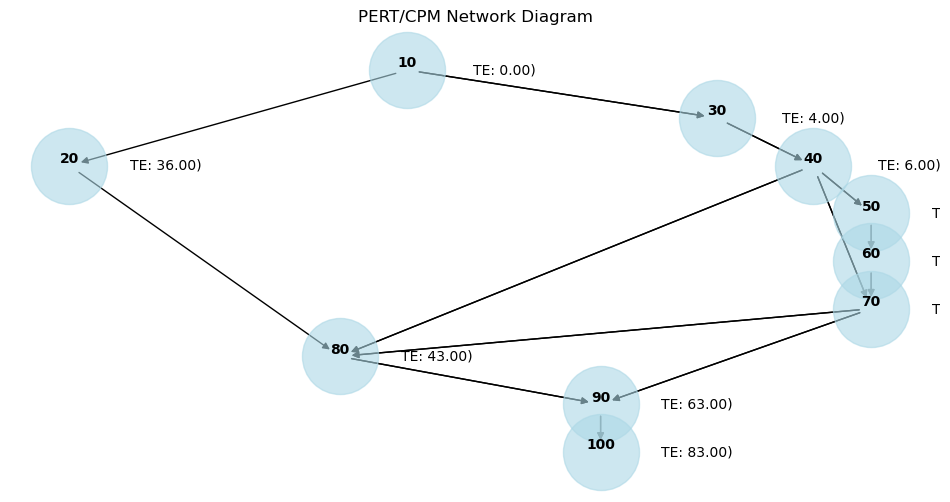

In [215]:
# Example activity data
activities = [
    ('1', '2', 36),   #A
    ('1', '3', 4),    #B
    ('3', '4', 2),    #C
    ('2', '8', 2),    #D
    ('4', '8', 10),   #E
    ('4', '5', 15),   #F
    ('5', '6', 4),    #G
    ('6', '7', 9),    #H
    ('4', '7', 9),    #I
    ('7', '8', 9),    #J
    ('8', '9', 20),   #K
    ('7', '9', 8),    #L
    ('9', '10', 20)   #M
]

# Create the PERT/CPM network with the enhanced visualization
create_pert_network(activities)

# 4

Activity  duration
     1-2         5
     2-3         2
     2-4         6
     3-6         4
     3-5         4
     4-5         2
     4-7         3
     6-8         8
     5-8         7
     7-8         2

Node details (TE):
Node 1 (Fulkerson 10) -> TE: 0.00
Node 2 (Fulkerson 20) -> TE: 5.00
Node 3 (Fulkerson 30) -> TE: 7.00
Node 4 (Fulkerson 40) -> TE: 11.00
Node 6 (Fulkerson 60) -> TE: 11.00
Node 5 (Fulkerson 50) -> TE: 13.00
Node 7 (Fulkerson 70) -> TE: 14.00
Node 8 (Fulkerson 80) -> TE: 20.00
Critical Path: ['1', '2', '4', '5', '8']
Critical Path Length: 20.00


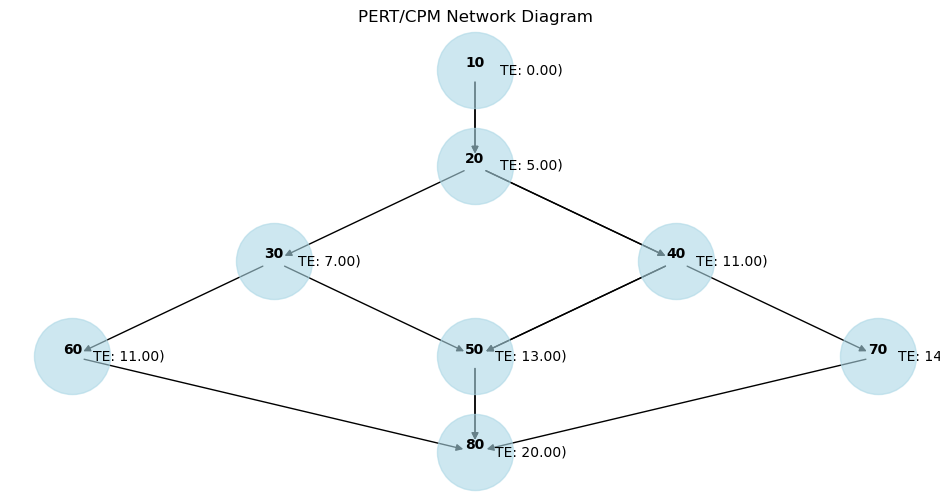

In [218]:
# Example activity data
activities = [
    ('1', '2', 5),   #A
    ('2', '3', 2),   #B
    ('2', '4', 6),   #C
    ('3', '6', 4),   #D
    ('3', '5', 4),   #E
    ('4', '5', 2),   #F
    ('4', '7', 3),   #G
    ('6', '8', 8),   #H
    ('5', '8', 7),   #I
    ('7', '8', 2)    #J
]

# Create the PERT/CPM network with the enhanced visualization
create_pert_network(activities)

# 5

Activity  duration
     1-2        10
     2-3        12
     2-7        12
     2-5         8
     3-4         6
     4-5         8
     3-6         5
     5-6         8
     5-7        10
     6-7         6
     7-8        12

Node details (TE):
Node 1 (Fulkerson 10) -> TE: 0.00
Node 2 (Fulkerson 20) -> TE: 10.00
Node 3 (Fulkerson 30) -> TE: 22.00
Node 7 (Fulkerson 70) -> TE: 50.00
Node 5 (Fulkerson 50) -> TE: 36.00
Node 4 (Fulkerson 40) -> TE: 28.00
Node 6 (Fulkerson 60) -> TE: 44.00
Node 8 (Fulkerson 80) -> TE: 62.00
Critical Path: ['1', '2', '3', '4', '5', '6', '7', '8']
Critical Path Length: 62.00


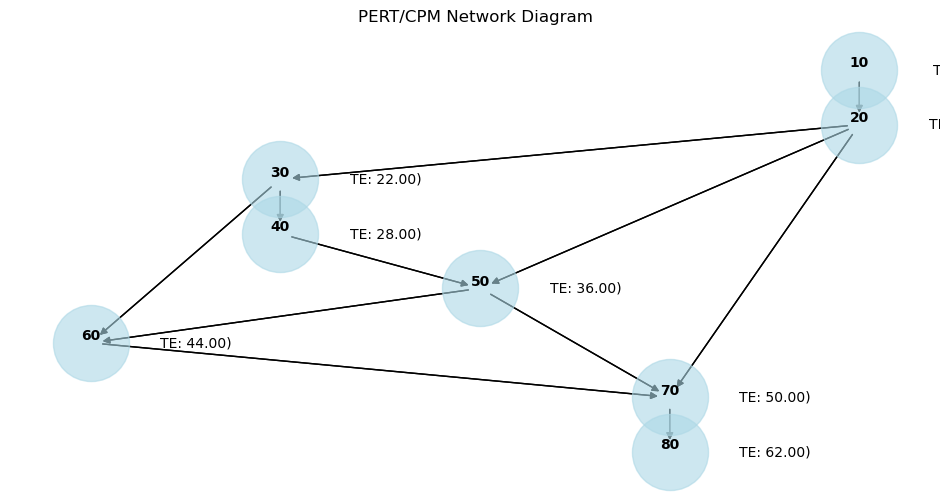

In [221]:
# Example activity data
activities = [
    ('1', '2',10),
    ('2', '3', 12),
    ('2', '7', 12),
    ('2', '5', 8),
    ('3', '4', 6),
    ('4', '5', 8),
    ('3', '6', 5),
    ('5', '6', 8),
    ('5', '7', 10),
    ('6', '7', 6),
    ('7', '8', 12)
]

# Create the PERT/CPM network with the enhanced visualization
create_pert_network(activities)

# 2, 3, 6

In [245]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.drawing.nx_pydot import graphviz_layout

# Function to calculate expected time TE using the PERT formula
def calculate_te(to, tm, tp):
    return (to + 4 * tm + tp) / 6

# Function to compute TE and variance for each activity
def compute_te(activities):
    data = []
    for start, end, to, tm, tp in activities:
        te = calculate_te(to, tm, tp)
        variance = ((tp - to) / 6) ** 2
        data.append({
            'Activity': f'{start}-{end}',
            'to': to,
            'tm': tm,
            'tp': tp,
            'tE': f"{te:.2f}",
            'σ²': f"{variance:.2f}"
        })
    df = pd.DataFrame(data)
    print(df.to_string(index=False))
    return data

# Function to apply Fulkerson's Rule for numbering nodes
def apply_fulkerson_numbering(G):
    numbering = {}
    current_number = 10
    remaining_nodes = set(G.nodes())
    
    while remaining_nodes:
        initial_nodes = {node for node in remaining_nodes if all(pred in numbering for pred in G.predecessors(node))}
        for node in sorted(initial_nodes):
            numbering[node] = current_number
            current_number += 10
            remaining_nodes.remove(node)
    return numbering

# Function to find the critical path using longest path in a DAG
def find_critical_path(G):
    # Initialize Early Start (ES) and Late Finish (LF) times for each node
    for node in G.nodes():
        G.nodes[node]['ES'] = 0
        G.nodes[node]['LF'] = float('inf')
    
    # Forward pass to calculate ES (Early Start) times
    for node in nx.topological_sort(G):
        for successor in G.successors(node):
            G.nodes[successor]['ES'] = max(G.nodes[successor].get('ES', 0), G.nodes[node]['ES'] + G[node][successor]['duration'])

    # Backward pass to calculate LF (Late Finish) times
    for node in reversed(list(nx.topological_sort(G))):
        if not list(G.successors(node)):  # If no successors, LF equals ES (end node)
            G.nodes[node]['LF'] = G.nodes[node]['ES']
        for predecessor in G.predecessors(node):
            G.nodes[predecessor]['LF'] = min(G.nodes[predecessor].get('LF', float('inf')), G.nodes[node]['LF'] - G[predecessor][node]['duration'])
     # Printing the Event Time (TE) details
    print("\nNode details (TE):")
    for node in G.nodes():
        te = G.nodes[node].get('ES', 0)  # TE is the Early Start time
        print(f"Node {node} (Fulkerson {G.nodes[node]['fulkerson_number']}) -> TE: {te:.2f}")

    critical_path = nx.dag_longest_path(G, weight='duration')
    critical_path_length = nx.dag_longest_path_length(G, weight='duration')  
    return critical_path, critical_path_length

# Function to create and visualize the PERT/CPM network diagram with Critical Path and Slack
def create_pert_network(activities):
    # Compute TE and variance for each activity
    activity_data = compute_te(activities)

    # Initialize directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph using calculated TE values
    for item in activity_data:
        start, end = item['Activity'].split('-')
        te = float(item['tE'])  # Ensure TE is treated as a float
        G.add_edge(start, end, duration=te)

    # Apply Fulkerson's Rule for numbering the events
    fulkerson_numbers = apply_fulkerson_numbering(G)
    nx.set_node_attributes(G, fulkerson_numbers, 'fulkerson_number')

    # Find the critical path using the longest path algorithm
    critical_path, critical_path_length = find_critical_path(G)

    # Print critical path and its length
    print(f"Critical Path: {critical_path}")
    print(f"Critical Path Length: {critical_path_length:.2f}")

     # Automatic position layout using Graphviz
    pos = graphviz_layout(G, prog="dot")

    # Draw the graph with the computed positions
    plt.figure(figsize=(12, 6))
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=3000, alpha=0.6)
    
    # Draw node labels with only Fulkerson numbers
    labels = {node: fulkerson_numbers[node] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight="bold", verticalalignment="bottom")

    # Draw edges, using dashed style for dummy activities (TE = 0)
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        duration = data['duration']
        edge_labels[(u, v)] = f"{duration:.2f}"  # Format duration to 2 decimal places
        if duration == 0:  # Dummy activity
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], style=(0, (5, 10)), edge_color='black', width=1)
        else:
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], style='solid', edge_color='black', width=1)
    
    node_extra_labels = {}
    for node in G.nodes():
        te = G.nodes[node].get('ES', 0)
        node_extra_labels[node] = f"TE: {te:.2f})"
    label_pos = {node: (x + 10, y) for node, (x, y) in pos.items()}
    nx.draw_networkx_labels(G, label_pos, node_extra_labels, font_size=10, font_color="black")

    # Title and show the plot
    plt.title(f"PERT/CPM Network Diagram with Critical Path\nCritical Path: {', '.join(critical_path)}")
    plt.axis("off")
    plt.show()

# 2

Activity  to  tm  tp    tE   σ²
     1-2   6   9  18 10.00 4.00
     1-3   5   8  17  9.00 4.00
     2-5   4   7  10  7.00 1.00
     2-4   4   7  22  9.00 9.00
     3-4   4   7  16  8.00 4.00
     3-5   2   5   8  5.00 1.00
     4-5   4  10  22 11.00 9.00

Node details (TE):
Node 1 (Fulkerson 10) -> TE: 0.00
Node 2 (Fulkerson 20) -> TE: 10.00
Node 3 (Fulkerson 30) -> TE: 9.00
Node 5 (Fulkerson 50) -> TE: 30.00
Node 4 (Fulkerson 40) -> TE: 19.00
Critical Path: ['1', '2', '4', '5']
Critical Path Length: 30.00


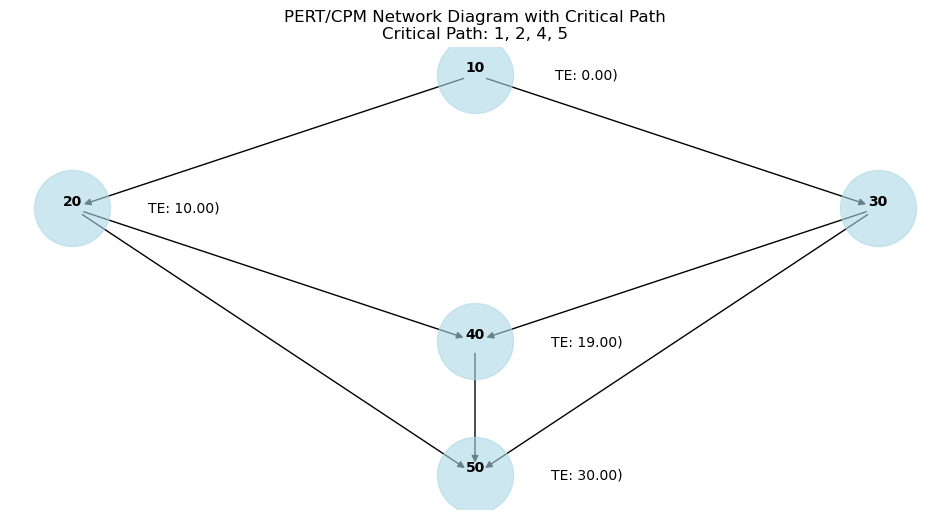

In [248]:
# Example activity data
activities = [
    ('1', '2', 6, 9, 18),
    ('1', '3', 5, 8, 17),
    ('2', '5', 4, 7, 10),
    ('2', '4', 4, 7, 22),
    ('3', '4', 4, 7, 16),
    ('3', '5', 2, 5, 8),
    ('4', '5', 4, 10, 22)
]

# Create the PERT/CPM network with the enhanced visualization
create_pert_network(activities)

# 3

Activity  to  tm  tp    tE   σ²
     1-2   6   8  11  8.17 0.69
     1-3   3   7   9  6.67 1.00
     1-4   5   7  10  7.17 0.69
     2-7   8  10  12 10.00 0.44
     3-6   8  10  12 10.00 0.44
     4-5   4   6   8  6.00 0.44
     2-6   4   8  14  8.33 2.78
     5-6   3   5   6  4.83 0.25
     6-8   7  10  15 10.33 1.78
     7-8   5   8  12  8.17 1.36

Node details (TE):
Node 1 (Fulkerson 10) -> TE: 0.00
Node 2 (Fulkerson 20) -> TE: 8.17
Node 3 (Fulkerson 30) -> TE: 6.67
Node 4 (Fulkerson 40) -> TE: 7.17
Node 7 (Fulkerson 60) -> TE: 18.17
Node 6 (Fulkerson 70) -> TE: 18.00
Node 5 (Fulkerson 50) -> TE: 13.17
Node 8 (Fulkerson 80) -> TE: 28.33
Critical Path: ['1', '4', '5', '6', '8']
Critical Path Length: 28.33


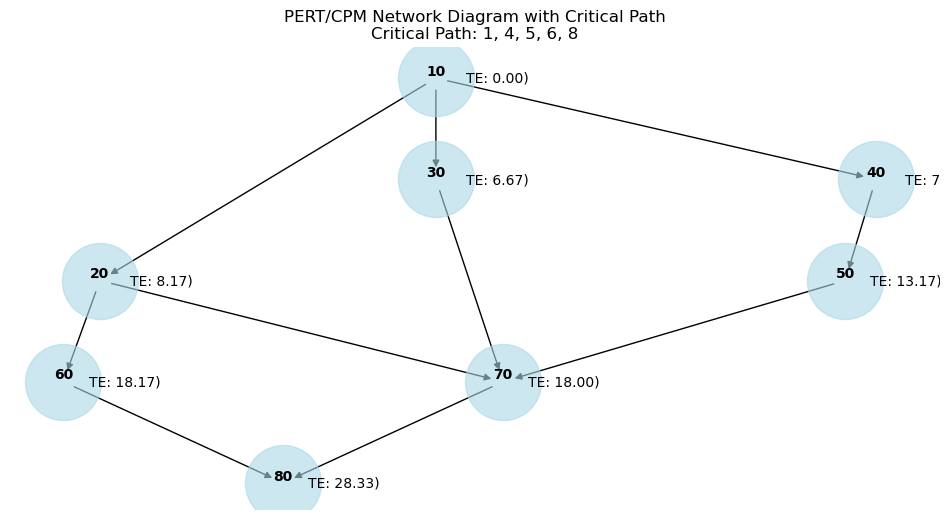

In [251]:
# Example activity data
activities = [
    ('1', '2', 6, 8, 11),
    ('1', '3', 3, 7, 9),
    ('1', '4', 5, 7, 10),
    ('2', '7', 8, 10, 12),
    ('3', '6', 8, 10, 12),
    ('4', '5', 4, 6, 8),
    ('2', '6', 4, 8, 14),
    ('5', '6', 3, 5, 6),
    ('6', '8', 7, 10, 15),
    ('7', '8', 5, 8, 12)
]

# Create the PERT/CPM network with the enhanced visualization
create_pert_network(activities)

# 6

Activity  to  tm  tp    tE   σ²
     1-2   4   8  12  8.00 1.78
     2-3   1   4   7  4.00 1.00
     2-4   8  12  16 12.00 1.78
     3-5   3   5   7  5.00 0.44
     4-5   0   0   0  0.00 0.00
     4-6   3   6   9  6.00 1.00
     5-8   4   6   8  6.00 0.44
     5-7   3   6   9  6.00 1.00
     8-9   2   5   8  5.00 1.00
     7-9   4   8  12  8.00 1.78
    9-10   4  10  16 10.00 4.00
    6-10   4   6   8  6.00 0.44

Node details (TE):
Node 1 (Fulkerson 10) -> TE: 0.00
Node 2 (Fulkerson 20) -> TE: 8.00
Node 3 (Fulkerson 30) -> TE: 12.00
Node 4 (Fulkerson 40) -> TE: 20.00
Node 5 (Fulkerson 50) -> TE: 20.00
Node 6 (Fulkerson 60) -> TE: 26.00
Node 8 (Fulkerson 80) -> TE: 26.00
Node 7 (Fulkerson 70) -> TE: 26.00
Node 9 (Fulkerson 90) -> TE: 34.00
Node 10 (Fulkerson 100) -> TE: 44.00
Critical Path: ['1', '2', '4', '5', '7', '9', '10']
Critical Path Length: 44.00


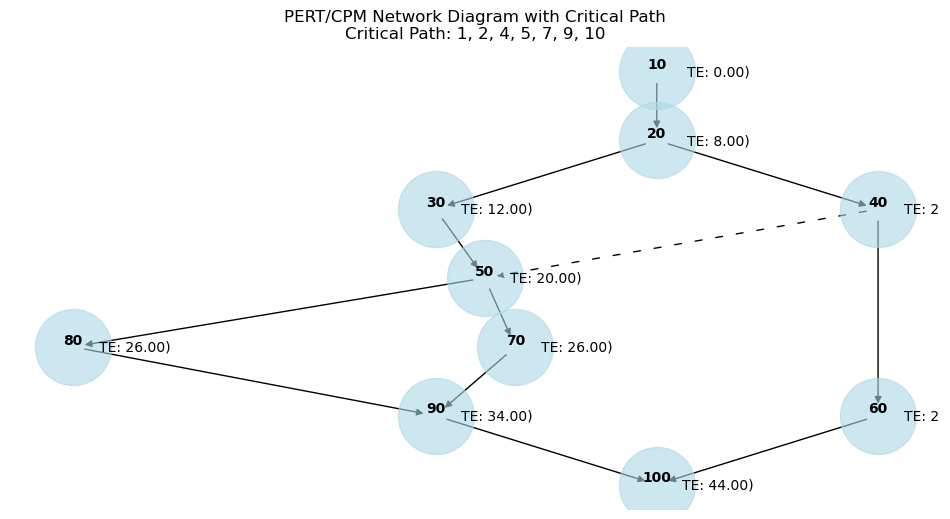

In [254]:
# Example activity data
activities = [
    ('1', '2', 4, 8, 12),
    ('2', '3', 1, 4, 7),
    ('2', '4', 8, 12, 16),
    ('3', '5', 3, 5, 7),
    ('4', '5', 0, 0, 0),
    ('4', '6', 3, 6, 9),
    ('5', '8', 4, 6, 8),
    ('5', '7', 3, 6, 9),
    ('8', '9', 2, 5, 8),
    ('7', '9', 4, 8, 12),
    ('9', '10', 4, 10, 16),
    ('6', '10', 4, 6, 8)
]

# Create the PERT/CPM network with the enhanced visualization
create_pert_network(activities)